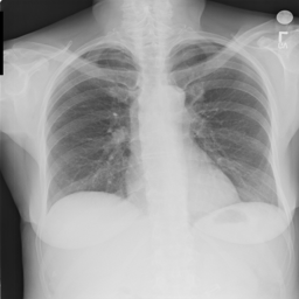

In [69]:
import numpy as np
import tensorflow as tf
import keras

import os
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline
from funcs_Task3 import concat_generators
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

img_size = (128, 128)

# The local path to our target image
#img_path = "covid xray/test/COVID/COVID-2032.png"
img_path = "covid xray/test/NORMAL/NORMAL-2030.png"
display(Image(img_path))

In [2]:
loaded_model = tf.keras.models.load_model('covid_xray_model.h5')  # Load the model
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,725,507 (14.21 MB)

 Trainable params: 3,725,377 (14.21 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2 (12.00 B)

### Redefine model so I have different output layer -> shape (1,2)

- We have to change the last layer to not have a scalar as output
- I here redefined the model completely because in task 2 I made it with sequential() and then it doesn't work for some reason

In [44]:
from tensorflow.keras import datasets, layers, models
METRICS = ["accuracy"]
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'
epochs = 30

#full_data_gen = training_data_Pipeline(128, img_size, 'covid xray/train_val')
training_data_gen = training_data_Pipeline(batch_size, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, val_dir)
full_data_gen = concat_generators(training_data_gen, val_data_gen)

total_train = training_data_gen.samples + val_data_gen.samples  #
total_val = val_data_gen.samples

learning_rate = 0.001
dropout_rate = 0.3
filters = 32

inputs = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', name="last_conv")(x)  # <-- Name this layer for Grad-CAM
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)  

redefined_model = Model(inputs, outputs)

redefined_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

redefined_model.summary()

history = redefined_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,853,666 (7.07 MB)

 Trainable params: 1,853,602 (7.07 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5850 - loss: 0.7034   

c:\Users\Marcin\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5881 - loss: 0.7004 - val_accuracy: 0.5625 - val_loss: 0.6692
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 978ms/step - accuracy: 0.7076 - loss: 0.5703 - val_accuracy: 0.5000 - val_loss: 0.7092
Epoch 3/30


c:\Users\Marcin\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7318 - loss: 0.5339 - val_accuracy: 0.5990 - val_loss: 0.6494
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 939ms/step - accuracy: 0.7645 - loss: 0.4941 - val_accuracy: 0.5000 - val_loss: 0.7072
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7474 - loss: 0.4920 - val_accuracy: 0.6615 - val_loss: 0.6262
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 939ms/step - accuracy: 0.7478 - loss: 0.4990 - val_accuracy: 0.4375 - val_loss: 0.7064
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7943 - loss: 0.4501 - val_accuracy: 0.6901 - val_loss: 0.6031
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 950ms/step - accuracy: 0.7762 - loss: 0.4609 - val_accuracy: 0.6250 - val_loss: 0.6494
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8078 - loss: 0.4253 - val_accuracy: 0.7240 - val_loss: 0.5876
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 962ms/step - accuracy: 0.7727 - loss: 0.4342 - val_accuracy: 0.4375 - val_los

### Functions to get image array and to make Grad-CAM map (from tutorial)

In [70]:
def get_img_array(img_path, size):

    img = keras.utils.load_img(img_path, target_size=size)

    array = keras.utils.img_to_array(img)

    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, sublayer = None, pred_index=None):
    
    if sublayer is None:
        output = model.get_layer(last_conv_layer_name).output
    else:
        output = model.get_layer(last_conv_layer_name).get_layer(sublayer).output

    # First, we create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        
        model.inputs, [output, model.output]
    )

    # We compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        # For binary classification, just get the scalar output ????
        class_channel = preds[0][pred_index]

    # This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Average the gradients along the spatial dimension to get a proxy for the channel importance
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    #averaging the activations along the channel dimension, weighting each channel according to its importance
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

### grad-CAM for redefined baseline model

Image shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(1, 2)
[[ 0.4122393 -0.8350369]] tf.Tensor([[0.776828   0.22317198]], shape=(1, 2), dtype=float32)


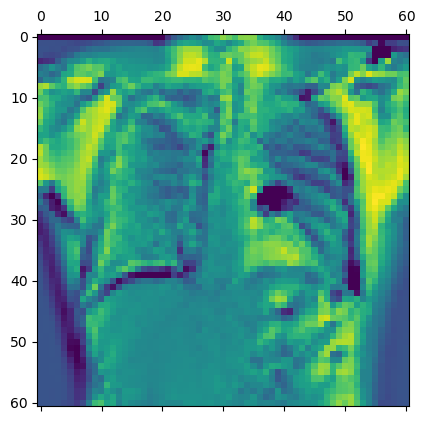

In [91]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print("Image shape:", img_array.shape)

redefined_model.layers[-1].activation = None

# Print what the top predicted class is
preds = redefined_model.predict(img_array)
print(preds.shape)
print(preds, tf.nn.softmax(preds))
heatmap = make_gradcam_heatmap(img_array, redefined_model, "last_conv", pred_index=0)

# Display heatmap
plt.matshow(heatmap)
plt.show()


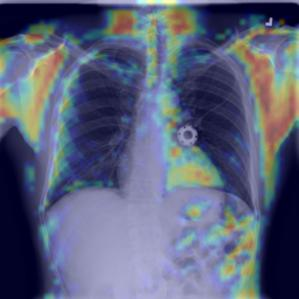

In [93]:
def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, threshold=0.5):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


display_gradcam(img_path, heatmap)


COVID:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: COVID-2053.png | Predictions (softmax output): [[0.9300144  0.06998562]]


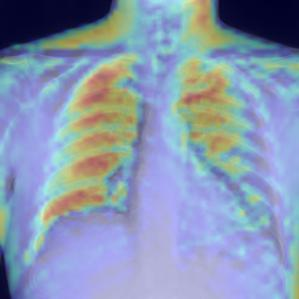

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: COVID-2033.png | Predictions (softmax output): [[0.9422603  0.05773965]]


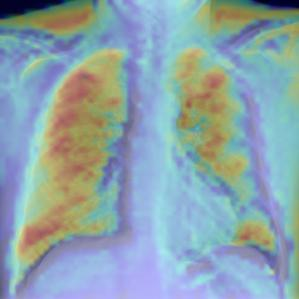

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Image: COVID-2022.png | Predictions (softmax output): [[0.89449954 0.1055004 ]]


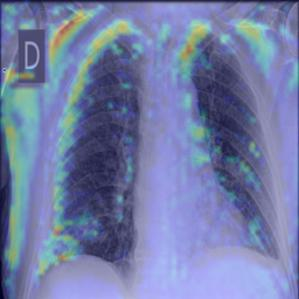


NORMAL:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: Normal-2006.png | Predictions (softmax output): [[0.7550441  0.24495593]]


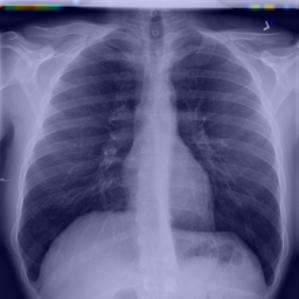

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: Normal-2073.png | Predictions (softmax output): [[0.89498323 0.10501675]]


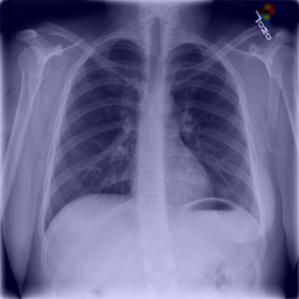

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: Normal-2019.png | Predictions (softmax output): [[0.8236477  0.17635229]]


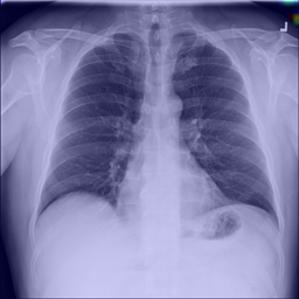

In [121]:
covid_folder = "covid xray/test/COVID"
normal_folder = "covid xray/test/NORMAL"

import random
# Pick random 3 images from each
covid_images = random.sample(os.listdir(covid_folder), 3)
normal_images = random.sample(os.listdir(normal_folder), 3)


# ----------- LOOP FOR COVID -----------
print("\nCOVID:\n")
for img_name in covid_images:
    img_path = os.path.join(covid_folder, img_name)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    redefined_model.layers[-1].activation = None
    preds = redefined_model.predict(img_array)
    print(f"Image: {img_name} | Predictions (softmax output): {tf.nn.softmax(preds)}")
    heatmap = make_gradcam_heatmap(img_array, redefined_model, "last_conv", pred_index=0)
    display_gradcam(img_path, heatmap)

# ----------- LOOP FOR NORMAL -----------
print("\nNORMAL:\n")
for img_name in normal_images:
    img_path = os.path.join(normal_folder, img_name)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    redefined_model.layers[-1].activation = None
    preds = redefined_model.predict(img_array)
    print(f"Image: {img_name} | Predictions (softmax output): {tf.nn.softmax(preds)}")
    heatmap = make_gradcam_heatmap(img_array, redefined_model, "last_conv", pred_index=1)
    display_gradcam(img_path, heatmap)

with pred_index = 0 you see the activation contributing to making the decision of covid
with pred_index = 1 you see the activation contributing to making the decision of normal

Looks like they are always classified as COVI


### Now lets try for Resnet model of task 3

In [75]:
loaded_model = load_model("ResNet_finetuned_model.keras")
loaded_model.summary()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Get all layers except the last one
x = loaded_model.layers[-2].output  # or however many layers back you want to go
outputs = Dense(2)(x)

# Create a new model with modified output
new_model = Model(inputs=loaded_model.input, outputs=outputs)

# Compile with new loss (e.g., categorical crossentropy if 1000-class classification)
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,352,005 (92.90 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 524,804 (2.00 MB)

Model: "functional_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,330 (90.89 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [76]:
#last sublayers inside resnet
print(new_model.get_layer("resnet50v2").layers[-1].name)
print(new_model.get_layer("resnet50v2").layers[-2].name)
print(new_model.get_layer("resnet50v2").layers[-3].name)

post_relu
post_bn
conv5_block3_out


### Model from task 3: doesn't work 
- It seem that we cannot get to the output of the convolutional layers that are inside the pretrained resnet block
- Maybe we could add another conv layer to the model so we can get that output
- Or maybe there is a way to store resnet output while making the model in task 3?

In [77]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print("Image shape:", img_array.shape)

new_model.layers[-1].activation = None

preds = new_model.predict(img_array)
print(preds.shape)

heatmap = make_gradcam_heatmap(img_array, new_model, "resnet50v2", sublayer="conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.show()

Image shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1, 2)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m1540294444848\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         ...,\n         [-0.52156866, -0.52156866, -0.52156866],\n         [-0.40392154, -0.40392154, -0.40392154],\n         [-0.09019607, -0.09019607, -0.09019607]],\n\n        [[-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         ...,\n         [-0.8980392 , -0.8980392 , -0.8980392 ],\n         [-0.8901961 , -0.8901961 , -0.8901961 ],\n         [-0.81960785, -0.81960785, -0.81960785]],\n\n        [[-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         ...,\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9529412 , -0.9529412 , -0.9529412 ]],\n\n        ...,\n\n        [[-0.5764706 , -0.5764706 , -0.5764706 ],\n         [-0.27058822, -0.27058822, -0.27058822],\n         [ 0.03529418,  0.03529418,  0.03529418],\n         ...,\n         [-0.84313726, -0.84313726, -0.84313726],\n         [-0.9607843 , -0.9607843 , -0.9607843 ],\n         [-0.9137255 , -0.9137255 , -0.9137255 ]],\n\n        [[-0.6       , -0.6       , -0.6       ],\n         [-0.25490195, -0.25490195, -0.25490195],\n         [ 0.05882359,  0.05882359,  0.05882359],\n         ...,\n         [-0.6392157 , -0.6392157 , -0.6392157 ],\n         [-0.4352941 , -0.4352941 , -0.4352941 ],\n         [-0.27843136, -0.27843136, -0.27843136]],\n\n        [[-0.6156863 , -0.6156863 , -0.6156863 ],\n         [-0.30196077, -0.30196077, -0.30196077],\n         [ 0.04313731,  0.04313731,  0.04313731],\n         ...,\n         [-0.6156863 , -0.6156863 , -0.6156863 ],\n         [-0.49019605, -0.49019605, -0.49019605],\n         [-0.41176468, -0.41176468, -0.41176468]]]], dtype=float32)\n  • training=None\n  • mask=None'

# Explaining the decision with Grad-CAM

In [ ]:
def get_gradcam_image(img_path, heatmap, alpha=0.4, threshold=0.8):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return(superimposed_img)


In [ ]:
## divide test data into groups
# gather necessary data
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = loaded_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_data_gen.classes

filepaths = test_data_gen.filepaths
class_indices = test_data_gen.class_indices

# save filepaths of images in 4 classes, based on right or wrong classification and true value
y_pred_covid = (y_pred == class_indices["COVID"])
y_true_covid = (y_true == class_indices["COVID"])

Covid_misclassified = [filepaths[i] for i in range(len(filepaths)) if y_true_covid[i] & ~y_pred_covid[i]]
Covid_correctclassified = [filepaths[i] for i in range(len(filepaths))  if y_true_covid[i] & y_pred_covid[i]]
normal_misclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & y_pred_covid[i]]
normal_correctclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & ~y_pred_covid[i]]


In [ ]:
# sanity check classes
len(Covid_misclassified)+len(Covid_correctclassified)+len(normal_correctclassified)+len(normal_misclassified)

In [ ]:
# function plotting some images with grad-cam
def show_some_gradcams_from_list(list, img_size, model, start_index = 0, stop_index = 5 ):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(list[start_index:stop_index]):
        # make gradcam image
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, model, "last_conv")
        img = get_gradcam_image(img_path, heatmap)

        # plot gradcam image
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [ ]:
#Covid cases that are misclassified by the model as normal
show_some_gradcams_from_list(Covid_misclassified, img_size, redefined_model, start_index = 20, stop_index = 25 )

In [ ]:
#Covid cases that are correctly classified by the model 
show_some_gradcams_from_list(Covid_correctclassified, img_size, redefined_model, start_index = 20, stop_index = 25 )

In [ ]:
#normal cases that are incorrectly classified by the model as covid cases
show_some_gradcams_from_list(normal_misclassified, img_size, redefined_model, start_index = 5, stop_index = 10 )

In [ ]:
#normal cases that are correctly classified by the model
show_some_gradcams_from_list(normal_correctclassified, img_size, redefined_model, start_index = 0, stop_index = 5 )